In [9]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso

import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import SGDRegressor

# V1

## Carregamento dos dados

In [68]:
data = pd.read_csv('../datasets/fish.csv')

In [69]:
data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [70]:
cols = ['especie','peso','comprimento_corpo','comprimento_ate_base_rabo','comprimento_total','altura','largura']
data.columns = cols

In [71]:
data.head()

,especie,peso,comprimento_corpo,comprimento_ate_base_rabo,comprimento_total,altura,largura
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [72]:
data.shape

(159, 7)

## Descrição dos dados

### checar data types

In [73]:
data.dtypes 

especie                       object
peso                         float64
comprimento_corpo            float64
comprimento_ate_base_rabo    float64
comprimento_total            float64
altura                       float64
largura                      float64
dtype: object

### checar dados faltantes

In [74]:
data.isnull().sum()

especie                      0
peso                         0
comprimento_corpo            0
comprimento_ate_base_rabo    0
comprimento_total            0
altura                       0
largura                      0
dtype: int64

### estatisticas descritivas

In [75]:
num_attributes = data.select_dtypes(include='float64')
cat_attributes = data.select_dtypes(exclude='float64')

#### dados numéricos

In [76]:
def cria_tabela_estatistica(data):
    num_attributes = data.select_dtypes(include='float64')
    #medidas tendencia central
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    #medidas de dispersão - std,skew,kurtosis,min,max,range

    ct3 = pd.DataFrame(num_attributes.apply( np.std ) ).T
    ct4 = pd.DataFrame(num_attributes.apply( min ) ).T
    ct5 = pd.DataFrame(num_attributes.apply( max ) ).T
    ct6 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
    ct7 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T
    ct8 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() ) ).T

    #concatenate

    metrics = pd.concat([ct4,ct5,ct8,ct1,ct2,ct3,ct7,ct6]).T.reset_index()
    metrics.columns = ['attributes','min','max','amplitude','media','mediana','std','kurtosis','skew']
    metrics
    return metrics 

metrics = cria_tabela_estatistica(data=data)
metrics

,attributes,min,max,amplitude,media,mediana,std,kurtosis,skew
0,peso,0.0000,1650.000,1650.0000,398.326415,273.0000,356.850823,0.883841,1.104450
1,comprimento_corpo,7.5000,59.000,51.5000,26.247170,25.2000,9.964956,0.439774,0.588482
2,comprimento_ate_base_rabo,8.4000,63.400,55.0000,28.415723,27.3000,10.682576,0.403751,0.539863
3,comprimento_total,8.8000,68.000,59.2000,31.227044,29.4000,11.573678,0.075423,0.391541
4,altura,1.7284,18.957,17.2286,8.970994,7.7860,4.272708,-0.614174,0.397186
5,largura,1.0476,8.142,7.0944,4.417486,4.2485,1.680494,-0.534645,0.004972


In [77]:
# Variável peso possui um valor minimo de 0, o que não é possivel.
data.loc[data['peso']==0]

,especie,peso,comprimento_corpo,comprimento_ate_base_rabo,comprimento_total,altura,largura
40,Roach,0.0,19.0,20.5,22.8,6.4752,3.3516


In [78]:
#retirando esse dado temos:
data = data.loc[data['peso']>0]
metrics = cria_tabela_estatistica(data=data)
metrics

,attributes,min,max,amplitude,media,mediana,std,kurtosis,skew
0,peso,5.9000,1650.000,1644.1000,400.847468,281.50000,356.564044,0.879648,1.101685
1,comprimento_corpo,7.5000,59.000,51.5000,26.293038,25.30000,9.979695,0.428679,0.578149
2,comprimento_ate_base_rabo,8.4000,63.400,55.0000,28.465823,27.40000,10.697692,0.394103,0.529417
3,comprimento_total,8.8000,68.000,59.2000,31.280380,29.70000,11.590751,0.067852,0.380822
4,altura,1.7284,18.957,17.2286,8.986790,7.78900,4.281577,-0.625586,0.387337
5,largura,1.0476,8.142,7.0944,4.424232,4.27705,1.683656,-0.538620,-0.005539


#### dados categóricos

In [79]:
cat_attributes.apply(lambda x: x.unique().shape[0])

especie    7
dtype: int64

In [80]:
data['especie'].value_counts()

Perch        56
Bream        35
Roach        19
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: especie, dtype: int64

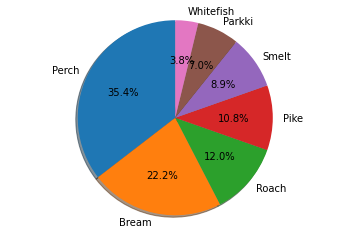

In [81]:
labels = ['Perch','Bream','Roach','Pike','Smelt','Parkki','Whitefish']
sizes = [56,35,19,17,14,11,6]
fig1, ax1 = plt.subplots()
ax1.pie(sizes,labels=labels,autopct='%1.1f%%',shadow=True,startangle=90)
ax1.axis('equal')
plt.show()

#Dados desbalanceados! - Proximas versões realizar um PCA.

## Análise Exploratória

In [16]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title="Analise Exploratoria Fish.csv")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Preparar Dados 

In [82]:
data = pd.get_dummies(data, prefix=['especie'],columns=['especie'])
data.head()

,peso,comprimento_corpo,comprimento_ate_base_rabo,comprimento_total,altura,largura,especie_Bream,especie_Parkki,especie_Perch,especie_Pike,especie_Roach,especie_Smelt,especie_Whitefish
0,242.0,23.2,25.4,30.0,11.5200,4.0200,1,0,0,0,0,0,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,1,0,0,0,0,0,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,1,0,0,0,0,0,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,1,0,0,0,0,0,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,1,0,0,0,0,0,0


array([[<AxesSubplot:title={'center':'peso'}>,
        <AxesSubplot:title={'center':'comprimento_corpo'}>],
       [<AxesSubplot:title={'center':'comprimento_ate_base_rabo'}>,
        <AxesSubplot:title={'center':'comprimento_total'}>],
       [<AxesSubplot:title={'center':'altura'}>,
        <AxesSubplot:title={'center':'largura'}>]], dtype=object)

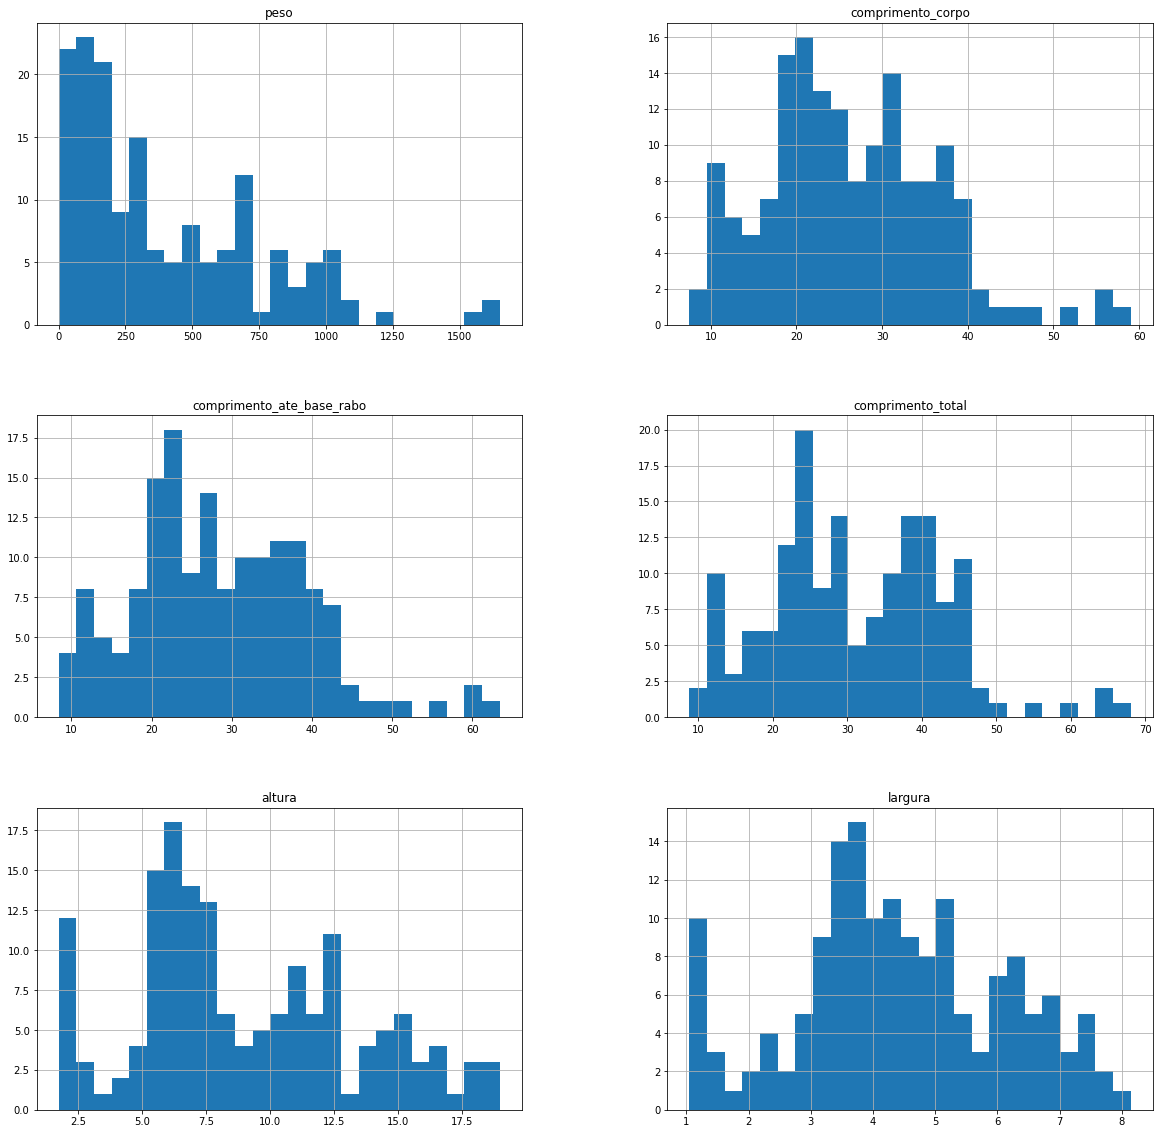

In [83]:
num_attributes.hist(bins=25,figsize=(20,20))

### Rescala dos dados


In [84]:
from sklearn import preprocessing as pp 
ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()
from sklearn.preprocessing import MaxAbsScaler
mas = pp.MaxAbsScaler()

In [85]:
data.dtypes 

peso                         float64
comprimento_corpo            float64
comprimento_ate_base_rabo    float64
comprimento_total            float64
altura                       float64
largura                      float64
especie_Bream                  uint8
especie_Parkki                 uint8
especie_Perch                  uint8
especie_Pike                   uint8
especie_Roach                  uint8
especie_Smelt                  uint8
especie_Whitefish              uint8
dtype: object

In [86]:
### Check ProfileReport to choose and scaler

### Normal distribution -> Stardardization
### Outlier -> Robust Scaler
### No normal no Outlier -> MinMax
### cyclical --> sin cos --> in 7.3 transformation

#peso -> minmax
#data['peso'] = mms.fit_transform( data[['peso']].values ) 

#comprimento_corpo ->
data['comprimento_corpo'] = mas.fit_transform(data[['comprimento_corpo']].values)

#comprimento_ate_base_rabo
data['comprimento_ate_base_rabo'] = mas.fit_transform(data[['comprimento_ate_base_rabo']].values)

#comprimento_total
data['comprimento_total'] = mas.fit_transform(data[['comprimento_total']].values)

#altura
data['altura'] = mas.fit_transform(data[['altura']].values)

#largura
data['largura'] = mas.fit_transform(data[['largura']].values)


In [87]:
data['peso'] = np.log1p(data['peso'])

## Modelos de Machine Learning

In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name':model_name,
                        'MAE':mae,
                        'MAPE':mape,
                        'RMSE':rmse},index=[0])

X = data.drop('peso',axis=1)
y = data['peso'].copy()

In [89]:
X.head()

,comprimento_corpo,comprimento_ate_base_rabo,comprimento_total,altura,largura,especie_Bream,especie_Parkki,especie_Perch,especie_Pike,especie_Roach,especie_Smelt,especie_Whitefish
0,0.393220,0.400631,0.441176,0.607691,0.493736,1,0,0,0,0,0,0
1,0.406780,0.414826,0.458824,0.658332,0.528814,1,0,0,0,0,0,0
2,0.405085,0.417981,0.457353,0.652941,0.576775,1,0,0,0,0,0,0
3,0.445763,0.457413,0.492647,0.671520,0.547224,1,0,0,0,0,0,0
4,0.449153,0.457413,0.500000,0.656433,0.630558,1,0,0,0,0,0,0


In [90]:
y.head()

0    5.493061
1    5.673323
2    5.831882
3    5.897154
4    6.066108
Name: peso, dtype: float64

### Regressao linear multipla

In [91]:
from sklearn.linear_model import LinearRegression, Lasso

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [92]:
#model
lr = LinearRegression().fit(X_train,y_train)

#prediction
yhat_lr = lr.predict(X_test)

#performance
lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,62.572613,0.126787,118.607263


###  Regressao Linear Regularizada LASSO

In [93]:
#model
lrr = Lasso(alpha=0.01).fit(X_train,y_train)

#prediction

yhat_lrr = lrr.predict(X_test)

#performance
lrr_result = ml_error('Lasso RegModel',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso RegModel,62.496782,0.134916,94.059013


### XGBoost Regressor

In [94]:
#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=90,
                             eta=0.09,
                             max_depth=100000,
                            subsample=0.7,
                            ).fit(X_train,y_train)
#predict
yhat_xgb = model_xgb.predict(X_test)
#performance
xgb_result = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb))  
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,50.798729,0.107531,72.533643


### Random Forest Regressor

In [95]:
#model
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42).fit(X_train,y_train)

#predict
yhat_rf = rf.predict(X_test)

#performance
rf_result = ml_error('Random Forest Regressor',np.expm1(y_test),np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,44.254102,0.106176,64.057036


### SGD Regressor

In [96]:

#model
sgd =SGDRegressor().fit(X_train,y_train)

#predict
yhat_sgd = sgd.predict(X_test)

#performance
sgd_result = ml_error('SGD Regressor',np.expm1(y_test),np.expm1(yhat_sgd))
sgd_result

,Model Name,MAE,MAPE,RMSE
0,SGD Regressor,64.079531,0.177651,100.767673


## Performance dos modelos

In [97]:
models = pd.concat([lr_result,lrr_result,rf_result,xgb_result,sgd_result])

models.sort_values('MAPE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,44.254102,0.106176,64.057036
0,XGBoost Regressor,50.798729,0.107531,72.533643
0,Linear Regression,62.572613,0.126787,118.607263
0,Lasso RegModel,62.496782,0.134916,94.059013
0,SGD Regressor,64.079531,0.177651,100.767673


### Tradução e Interpretação dos erros do modelo

In [36]:
data_teste = X_test.copy()
data_teste['peso'] = np.expm1(y_test)
data_teste['predicao_xgboost'] = np.expm1(yhat_rf)

data_teste_aux = data_teste[['peso','predicao_xgboost']].reset_index(drop=True)
data_teste_aux.head(50)

,peso,predicao_xgboost
0,300.0,282.114056
1,140.0,155.395347
2,510.0,402.875118
3,19.7,23.518876
4,130.0,145.410351
5,1000.0,862.248799
6,145.0,172.103187
7,180.0,185.570976
8,225.0,177.002836
9,1250.0,1321.759301


In [34]:
data_teste_aux.shape

(24, 2)

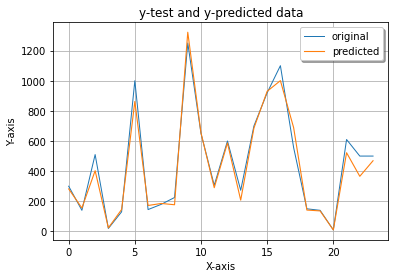

In [37]:
x_ax = range(len(y_test))
plt.plot(x_ax, data_teste_aux['peso'], linewidth=1, label="original")
plt.plot(x_ax, data_teste_aux['predicao_xgboost'], linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

# V2

## Carregamento dos dados

In [10]:
data = pd.read_csv('../datasets/fish.csv')

data.head()

cols = ['especie','peso','comprimento_corpo','comprimento_ate_base_rabo','comprimento_total','altura','largura']
data.columns = cols

data.head()

data.shape

(159, 7)

## Descrição dos dados

### checar data types

In [ ]:
data.dtypes 

### checar dados faltantes

In [11]:
data.isnull().sum()

especie                      0
peso                         0
comprimento_corpo            0
comprimento_ate_base_rabo    0
comprimento_total            0
altura                       0
largura                      0
dtype: int64

### estatisticas descritivas

In [6]:
num_attributes = data.select_dtypes(include='float64')
cat_attributes = data.select_dtypes(exclude='float64')

#### dados numéricos

In [ ]:
def cria_tabela_estatistica(data):
    num_attributes = data.select_dtypes(include='float64')
    #medidas tendencia central
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    #medidas de dispersão - std,skew,kurtosis,min,max,range

    ct3 = pd.DataFrame(num_attributes.apply( np.std ) ).T
    ct4 = pd.DataFrame(num_attributes.apply( min ) ).T
    ct5 = pd.DataFrame(num_attributes.apply( max ) ).T
    ct6 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
    ct7 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T
    ct8 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() ) ).T

    #concatenate

    metrics = pd.concat([ct4,ct5,ct8,ct1,ct2,ct3,ct7,ct6]).T.reset_index()
    metrics.columns = ['attributes','min','max','amplitude','media','mediana','std','kurtosis','skew']
    metrics
    return metrics 

metrics = cria_tabela_estatistica(data=data)
metrics

In [ ]:
# Variável peso possui um valor minimo de 0, o que não é possivel.
data.loc[data['peso']==0]

#retirando esse dado temos:
data = data.loc[data['peso']>0]
metrics = cria_tabela_estatistica(data=data)
metrics

#### dados categóricos

In [7]:
cat_attributes.apply(lambda x: x.unique().shape[0])

data['especie'].value_counts()

labels = ['Perch','Bream','Roach','Pike','Smelt','Parkki','Whitefish']
sizes = [56,35,19,17,14,11,6]
fig1, ax1 = plt.subplots()
ax1.pie(sizes,labels=labels,autopct='%1.1f%%',shadow=True,startangle=90)
ax1.axis('equal')
plt.show()

#Dados desbalanceados! - Proximas versões realizar um PCA.

KeyError: 'especie'

## Análise Exploratória

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(data, title="Analise Exploratoria Fish.csv")
profile.to_notebook_iframe()

## Preparar Dados 

array([[<AxesSubplot:title={'center':'Weight'}>,
        <AxesSubplot:title={'center':'Length1'}>],
       [<AxesSubplot:title={'center':'Length2'}>,
        <AxesSubplot:title={'center':'Length3'}>],
       [<AxesSubplot:title={'center':'Height'}>,
        <AxesSubplot:title={'center':'Width'}>]], dtype=object)

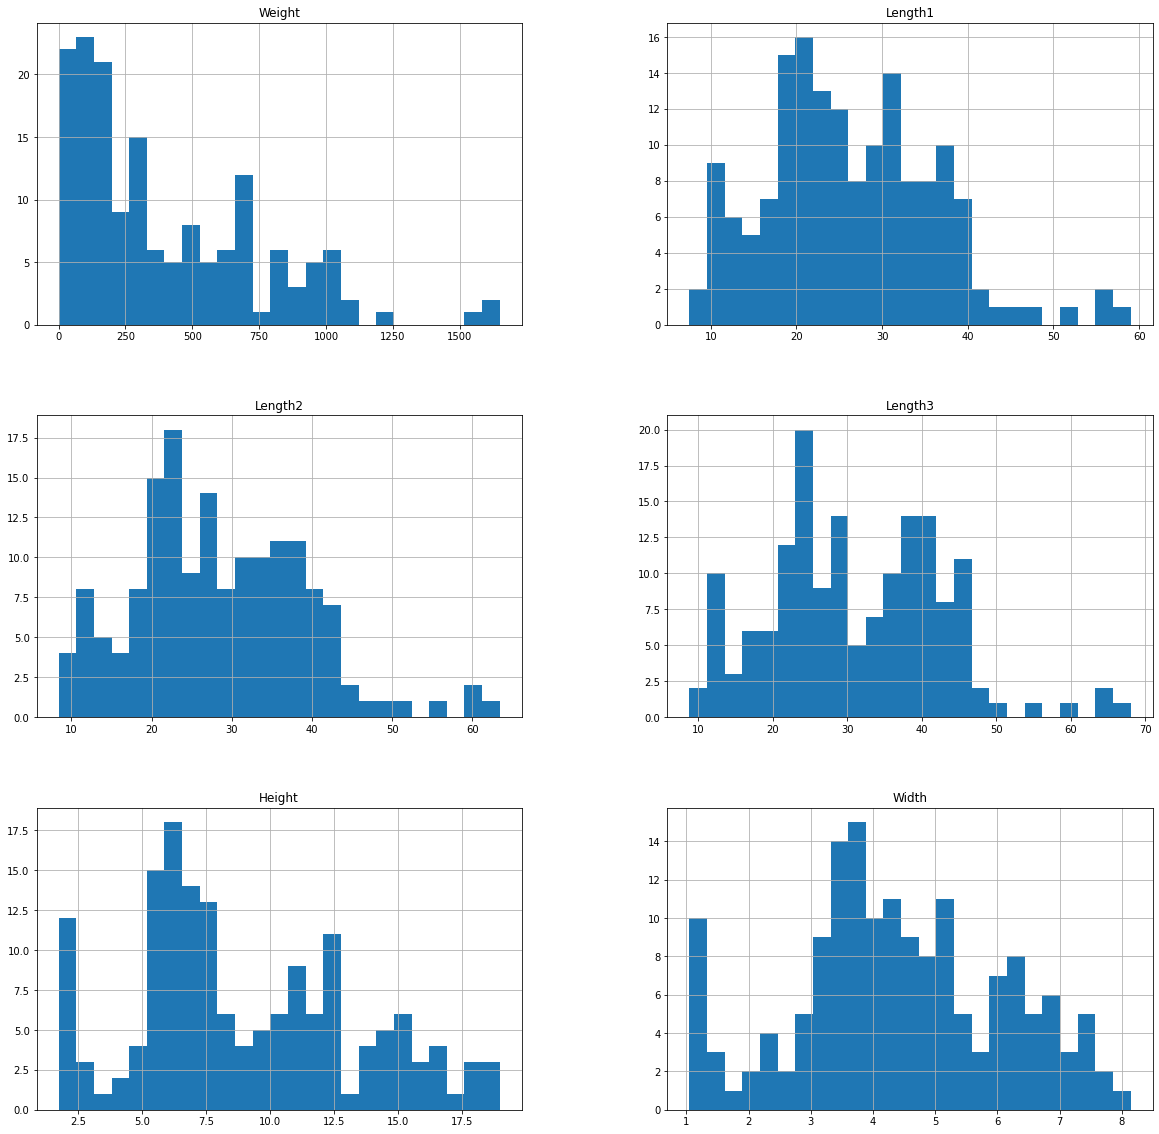

In [12]:
data = pd.get_dummies(data, prefix=['especie'],columns=['especie'])
data.head()

num_attributes.hist(bins=25,figsize=(20,20))

### Rescala dos dados

In [13]:
from sklearn import preprocessing as pp 
ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()
from sklearn.preprocessing import MaxAbsScaler
mas = pp.MaxAbsScaler()

data.dtypes 

### Check ProfileReport to choose and scaler

### Normal distribution -> Stardardization
### Outlier -> Robust Scaler
### No normal no Outlier -> MinMax
### cyclical --> sin cos --> in 7.3 transformation

#peso -> minmax
#data['peso'] = mms.fit_transform( data[['peso']].values ) 

#comprimento_corpo ->
data['comprimento_corpo'] = mas.fit_transform(data[['comprimento_corpo']].values)

#comprimento_ate_base_rabo
data['comprimento_ate_base_rabo'] = mas.fit_transform(data[['comprimento_ate_base_rabo']].values)

#comprimento_total
data['comprimento_total'] = mas.fit_transform(data[['comprimento_total']].values)

#altura
data['altura'] = mas.fit_transform(data[['altura']].values)

#largura
data['largura'] = mas.fit_transform(data[['largura']].values)


data['peso'] = np.log1p(data['peso'])

## Modelos de Machine Learning

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    
    return pd.DataFrame({'Model Name':model_name,
                        'MAE':mae,
                        'MAPE':mape,
                        'RMSE':rmse
                        },index=[0])

X = data.drop('peso',axis=1)
y = data['peso'].copy()

X.head()

y.head()



0    5.493061
1    5.673323
2    5.831882
3    5.897154
4    6.066108
Name: peso, dtype: float64

### RandomForest FineTuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}



#model
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_final = rf_random.fit(X_train,y_train)
#predict
yhat_rf = rf_finall.predict(X_test)

#performance
rf_result = ml_error('Random Forest Regressor',np.expm1(y_test),np.expm1(yhat_rf))
rf_result

Fitting 3 folds for each of 100 candidates, totalling 300 fits


### XGBoost Regressor Finetuning

In [ ]:
resultados = pd.DataFrame()
from sklearn.model_selection import GridSearchCV

parametros_gd= {'max_depth':[4,5,6,7,8,9],
                'learning_rate':[0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.2,0.3,0.4,0.5],
                'n_estimators':[30,40,50,60,70,80,90,100,110,120,130,140],
               'sumsample':[0.7,0.8,0.9,1]}





#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')

#searching the best hyperparameter -> THE DREAM!
grid_search = GridSearchCV(model_xgb,param_grid=parametros_gd,cv=5,n_jobs=-1,verbose=0)
grid_result = grid_search.fit(X_train,y_train)

final_model = model_xgb(objective='reg:squarederror',params=grid_result.best_params_).fit(X_train,y_train)

#predict
yhat_xgb = final_model.predict(X_test)
#performance
xgb_result = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb))  

xgb_result



## Performance dos modelos

In [ ]:
### Tradução e Interpretação dos erros do modelo

data_teste = X_test.copy()
data_teste['peso'] = np.expm1(y_test)
data_teste['predicao_xgboost'] = np.expm1(yhat_xgb)
data_teste['predicao_rf'] = np.expm1(yhat_rf)

data_teste_aux = data_teste[['peso','predicao_xgboost','predicao_rf']].reset_index(drop=True)
data_teste_aux.head(50)

data_teste_aux.shape

x_ax = range(len(y_test))
plt.plot(x_ax, data_teste_aux['peso'], linewidth=1, label="original")
plt.plot(x_ax, data_teste_aux['predicao_xgboost'], linewidth=1.1, label="xgboost")
plt.plot(x_ax, data_teste_aux['predicao_rf'], linewidth=1.1, label="randomforest")
plt.title("y-test and y-predicted data")
plt.xlabel('X-Axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 